# Optimal Pricing Strategy for Quick Sales


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser

In [3]:
file_path = r"C:\Users\omnia\Google Drive\Springboard\Assigments\Capestone 3\Optimal Pricing Strategy for Quick Sales\Wesley Chapel Agent Single Line CSV.csv"
WC_data = pd.read_csv(file_path)

In [4]:
WC_data.head()

,#,ML Number,Status,Address,City,Zip,Legal Subdivision Name,Subdivision/Condo Name,Heated Area,Current Price,...,Ownership,Tax,CDOM,ADOM,Days to Contract,Sold Terms,Close Date,LP / SqFt,SP/SqFt,SP / LP
0,1.0,W7870804,ACT,3844 KIM DR,WESLEY CHAPEL,33543.0,TERRACE PARK 01,NaN,576,"$105,500",...,Fee Simple,$321.00,35.0,35.0,NaN,NaN,NaN,$183.16,NaN,NaN
1,2.0,TB8329083,ACT,33843 TERRACE BLVD,WESLEY CHAPEL,33543.0,TERRACE PARK 02,NaN,864,"$134,900",...,Fee Simple,$215.58,34.0,34.0,NaN,NaN,NaN,$156.13,NaN,NaN
2,3.0,TB8330243,ACT,3836 CHRIS DR,WESLEY CHAPEL,33543.0,TERRACE PARK 02,NaN,600,"$139,900",...,Fee Simple,"$1,732.00",13.0,13.0,NaN,NaN,NaN,$233.17,NaN,NaN
3,4.0,O6263571,ACT,3145 HIDDEN LAKE DR,WESLEY CHAPEL,33543.0,TIMBER LAKE ESTATES,NaN,864,"$146,000",...,Condominium,$466.15,160.0,41.0,NaN,NaN,NaN,$168.98,NaN,NaN
4,5.0,TB8322494,ACT,33821 TERRACE BLVD,WESLEY CHAPEL,33543.0,TERRACE PARK,NaN,"1,620","$169,900",...,Fee Simple,$271.00,63.0,63.0,NaN,NaN,NaN,$104.88,NaN,NaN


In [5]:
WC_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   #                       5000 non-null   float64
 1   ML Number               5000 non-null   object 
 2   Status                  5000 non-null   object 
 3   Address                 5000 non-null   object 
 4   City                    5000 non-null   object 
 5   Zip                     5000 non-null   float64
 6   Legal Subdivision Name  4994 non-null   object 
 7   Subdivision/Condo Name  5 non-null      object 
 8   Heated Area             4975 non-null   object 
 9   Current Price           5000 non-null   object 
 10  Beds                    5000 non-null   float64
 11  Full Baths              5000 non-null   float64
 12  Half Baths              5000 non-null   float64
 13  Year Built              5000 non-null   float64
 14  Pool                    3462 non-null   

In [6]:
# Drop columns
columns_to_drop = ['#', 'ML Number', 'Address', 'Zip', 'Subdivision/Condo Name', 'Ownership', 'Tax']
WC_data = WC_data.drop(columns=columns_to_drop)
WC_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Status                  5000 non-null   object 
 1   City                    5000 non-null   object 
 2   Legal Subdivision Name  4994 non-null   object 
 3   Heated Area             4975 non-null   object 
 4   Current Price           5000 non-null   object 
 5   Beds                    5000 non-null   float64
 6   Full Baths              5000 non-null   float64
 7   Half Baths              5000 non-null   float64
 8   Year Built              5000 non-null   float64
 9   Pool                    3462 non-null   object 
 10  Property Style          5000 non-null   object 
 11  CDOM                    5000 non-null   float64
 12  ADOM                    5000 non-null   float64
 13  Days to Contract        4174 non-null   object 
 14  Sold Terms              3935 non-null   

In [7]:
# Clean special caracters 
columns_to_clean = ['Current Price', 'LP / SqFt', 'SP/SqFt', 'Heated Area']
for column in columns_to_clean:
    WC_data[column] = WC_data[column].replace(r'[\$]', '', regex=True).replace(',', '', regex=True).astype(float)

WC_data.info()
WC_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Status                  5000 non-null   object 
 1   City                    5000 non-null   object 
 2   Legal Subdivision Name  4994 non-null   object 
 3   Heated Area             4975 non-null   float64
 4   Current Price           5000 non-null   float64
 5   Beds                    5000 non-null   float64
 6   Full Baths              5000 non-null   float64
 7   Half Baths              5000 non-null   float64
 8   Year Built              5000 non-null   float64
 9   Pool                    3462 non-null   object 
 10  Property Style          5000 non-null   object 
 11  CDOM                    5000 non-null   float64
 12  ADOM                    5000 non-null   float64
 13  Days to Contract        4174 non-null   object 
 14  Sold Terms              3935 non-null   

,Status,City,Legal Subdivision Name,Heated Area,Current Price,Beds,Full Baths,Half Baths,Year Built,Pool,Property Style,CDOM,ADOM,Days to Contract,Sold Terms,Close Date,LP / SqFt,SP/SqFt,SP / LP
0,ACT,WESLEY CHAPEL,TERRACE PARK 01,576.0,105500.0,2.0,1.0,1.0,1973.0,NaN,Mobile Home - Pre 1976,35.0,35.0,NaN,NaN,NaN,183.16,NaN,NaN
1,ACT,WESLEY CHAPEL,TERRACE PARK 02,864.0,134900.0,2.0,1.0,0.0,1976.0,Community,Mobile Home - Pre 1976,34.0,34.0,NaN,NaN,NaN,156.13,NaN,NaN
2,ACT,WESLEY CHAPEL,TERRACE PARK 02,600.0,139900.0,1.0,1.0,0.0,2005.0,Community,Manufactured Home - Post 1977,13.0,13.0,NaN,NaN,NaN,233.17,NaN,NaN
3,ACT,WESLEY CHAPEL,TIMBER LAKE ESTATES,864.0,146000.0,2.0,2.0,0.0,1986.0,NaN,Mobile Home - Pre 1976,160.0,41.0,NaN,NaN,NaN,168.98,NaN,NaN
4,ACT,WESLEY CHAPEL,TERRACE PARK,1620.0,169900.0,2.0,2.0,0.0,1986.0,Community,Manufactured Home - Post 1977,63.0,63.0,NaN,NaN,NaN,104.88,NaN,NaN


In [8]:
# Convert Days to Contract & Heated Area to numeric 
WC_data[['Days to Contract', 'Heated Area']] = WC_data[['Days to Contract', 'Heated Area']].apply(pd.to_numeric, errors='coerce')

In [9]:
WC_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Status                  5000 non-null   object 
 1   City                    5000 non-null   object 
 2   Legal Subdivision Name  4994 non-null   object 
 3   Heated Area             4975 non-null   float64
 4   Current Price           5000 non-null   float64
 5   Beds                    5000 non-null   float64
 6   Full Baths              5000 non-null   float64
 7   Half Baths              5000 non-null   float64
 8   Year Built              5000 non-null   float64
 9   Pool                    3462 non-null   object 
 10  Property Style          5000 non-null   object 
 11  CDOM                    5000 non-null   float64
 12  ADOM                    5000 non-null   float64
 13  Days to Contract        4173 non-null   float64
 14  Sold Terms              3935 non-null   

In [10]:
# Converting Close date to date time
def safe_parse_date(date_str):
    try:
        return parser.parse(date_str)
    except Exception:
        return None

# Apply the function to the Close Date column
WC_data['Close Date'] = WC_data['Close Date'].apply(safe_parse_date)

print(WC_data['Close Date'].dtype)  

datetime64[ns]


In [11]:
WC_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Status                  5000 non-null   object        
 1   City                    5000 non-null   object        
 2   Legal Subdivision Name  4994 non-null   object        
 3   Heated Area             4975 non-null   float64       
 4   Current Price           5000 non-null   float64       
 5   Beds                    5000 non-null   float64       
 6   Full Baths              5000 non-null   float64       
 7   Half Baths              5000 non-null   float64       
 8   Year Built              5000 non-null   float64       
 9   Pool                    3462 non-null   object        
 10  Property Style          5000 non-null   object        
 11  CDOM                    5000 non-null   float64       
 12  ADOM                    5000 non-null   float64 

In [12]:
# Convert Close Date to datetime (handle NaN values)
WC_data['Close Date'] = pd.to_datetime(WC_data['Close Date'], errors='coerce')
WC_data['Close Date'].dtype

dtype('<M8[ns]')

In [13]:
# Handling missing values 
WC_data.loc[:, 'Pool'] = WC_data['Pool'].fillna('None')
WC_data.loc[:, 'Legal Subdivision Name'] = WC_data['Legal Subdivision Name'].fillna('Unknown')
WC_data.loc[:, 'Sold Terms'] = WC_data['Sold Terms'].fillna('Unknown')

In [14]:
status_count = WC_data['Status'].value_counts()
status_count

Status
SLD    3937
ACT     617
PND     237
EXP     209
Name: count, dtype: int64

In [15]:
# Drop rows with Nan in 'Status'
WC_data = WC_data.dropna(subset=['Status'])
WC_data.tail()

,Status,City,Legal Subdivision Name,Heated Area,Current Price,Beds,Full Baths,Half Baths,Year Built,Pool,Property Style,CDOM,ADOM,Days to Contract,Sold Terms,Close Date,LP / SqFt,SP/SqFt,SP / LP
4995,EXP,WESLEY CHAPEL,COUNTRY WALK INCREMENT C PH 02,2311.0,525000.0,4.0,2.0,1.0,2016.0,Community,Single Family Residence,43.0,43.0,NaN,Unknown,NaT,227.17,NaN,NaN
4996,EXP,WESLEY CHAPEL,EPPERSON NORTH,2615.0,589900.0,5.0,3.0,0.0,2022.0,Community,Single Family Residence,186.0,186.0,NaN,Unknown,NaT,225.58,NaN,NaN
4997,EXP,WESLEY CHAPEL,CIRCLE EIGHT PHASE 1,2756.0,650000.0,3.0,3.0,0.0,1982.0,None,Single Family Residence,313.0,313.0,NaN,Unknown,NaT,235.85,NaN,NaN
4998,EXP,WESLEY CHAPEL,EPPERSON RANCH SOUTH,2964.0,700000.0,5.0,3.0,0.0,2018.0,None,Single Family Residence,87.0,87.0,NaN,Unknown,NaT,236.17,NaN,NaN
4999,EXP,WESLEY CHAPEL,ACREAGE,6529.0,2450000.0,7.0,5.0,1.0,2023.0,Private,Single Family Residence,334.0,334.0,NaN,Unknown,NaT,375.25,NaN,NaN


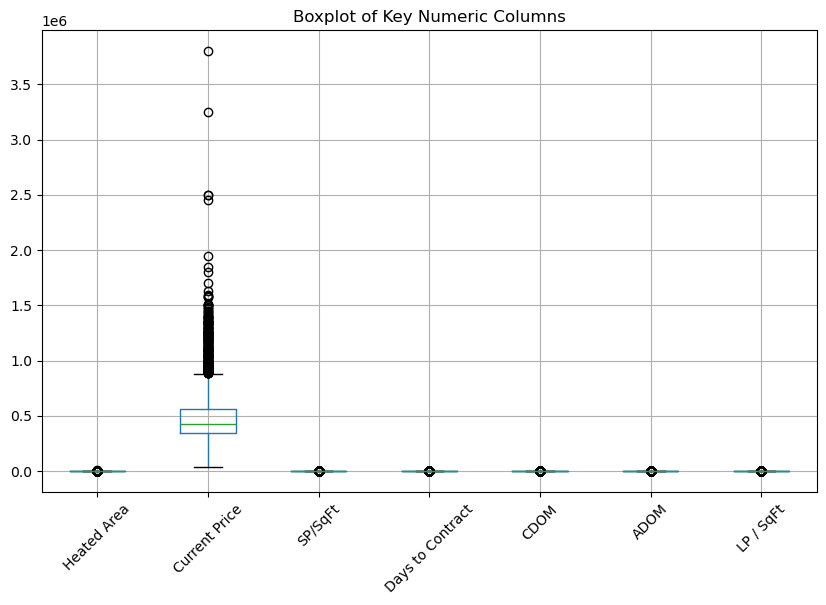

In [16]:
# Plot boxplot for key numeric columns
WC_data[['Heated Area', 'Current Price', 'SP/SqFt', 'Days to Contract', 'CDOM', 'ADOM', 'LP / SqFt']].boxplot(figsize=(10, 6))
plt.title('Boxplot of Key Numeric Columns')
plt.xticks(rotation=45)
plt.show()

In [17]:
WC_data['Current Price'].describe()

count    5.000000e+03
mean     4.864365e+05
std      2.242243e+05
min      4.000000e+04
25%      3.470000e+05
50%      4.309900e+05
75%      5.610288e+05
max      3.800000e+06
Name: Current Price, dtype: float64

In [18]:
# Define a function to detect outliers 
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 -Q1
    lower_bound = Q1 -1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR 

    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

In [19]:
price_outliers = detect_outliers(WC_data, 'Current Price')
print(price_outliers['Current Price'].describe())

count    2.460000e+02
mean     1.161865e+06
std      3.334775e+05
min      8.850000e+05
25%      9.499250e+05
50%      1.099450e+06
75%      1.263750e+06
max      3.800000e+06
Name: Current Price, dtype: float64


In [20]:
#Seprate the data
act_data = WC_data[WC_data['Status'] == 'ACT']
pnd_data = WC_data[WC_data['Status'] == 'PND']
exp_data = WC_data[WC_data['Status'] == 'EXP']
sold_data = WC_data[WC_data['Status'] == 'SLD']

In [21]:
# Extract month, year, day of the week
pd.options.mode.chained_assignment = None

sold_data.loc[:, 'Close Month'] = sold_data['Close Date'].dt.month
sold_data.loc[:, 'Close Year'] = sold_data['Close Date'].dt.year
sold_data.loc[:, 'Close Day of Week'] = sold_data['Close Date'].dt.day_name()

In [22]:
sold_data.head()

,Status,City,Legal Subdivision Name,Heated Area,Current Price,Beds,Full Baths,Half Baths,Year Built,Pool,...,ADOM,Days to Contract,Sold Terms,Close Date,LP / SqFt,SP/SqFt,SP / LP,Close Month,Close Year,Close Day of Week
399,SLD,WESLEY CHAPEL,FOX RIDGE,1512.0,135000.0,2.0,2.0,0.0,1980.0,None,...,0.0,-24.0,Cash,2024-11-25,89.29,89.29,1.00,11,2024,Monday
400,SLD,WESLEY CHAPEL,MEADOW POINTE PRCL 16 UNIT 02B,1184.0,156000.0,2.0,2.0,1.0,2002.0,None,...,2.0,2.0,Cash,2025-01-02,139.36,131.76,0.95,1,2025,Thursday
401,SLD,WESLEY CHAPEL,FOX RIDGE,1344.0,175000.0,3.0,2.0,0.0,1983.0,None,...,3.0,3.0,Cash,2024-12-05,148.74,130.21,0.88,12,2024,Thursday
402,SLD,WESLEY CHAPEL,MEADOW POINTE PRCL 16 UNIT 3A,1240.0,225000.0,2.0,2.0,1.0,2004.0,Community,...,32.0,52.0,Conventional,2025-01-16,189.44,181.45,0.96,1,2025,Thursday
403,SLD,WESLEY CHAPEL,THE TOWNHOMES AT RIVER LANDING,1373.0,234300.0,3.0,2.0,1.0,2024.0,Community,...,0.0,-37.0,Conventional,2024-12-17,170.65,170.65,1.00,12,2024,Tuesday


In [23]:
# Remove rows with negative values
sold_data = sold_data.loc[sold_data['Days to Contract'] >= 0]
sold_data.describe()

,Heated Area,Current Price,Beds,Full Baths,Half Baths,Year Built,CDOM,ADOM,Days to Contract,Close Date,LP / SqFt,SP/SqFt,SP / LP,Close Month,Close Year
count,3328.000000,3.328000e+03,3328.000000,3328.000000,3328.000000,3328.000000,3328.000000,3328.000000,3328.000000,3328,3328.000000,3328.000000,3328.000000,3328.000000,3328.000000
mean,2149.963642,4.583267e+05,3.575721,2.386719,0.414363,2014.609075,47.879207,45.051082,50.645132,2024-04-02 08:47:01.153846272,216.116653,212.717819,0.984967,7.051382,2023.702825
min,226.000000,4.000000e+04,1.000000,1.000000,0.000000,1950.000000,-7.000000,-7.000000,0.000000,2023-03-29 00:00:00,30.660000,39.410000,0.470000,1.000000,2023.000000
25%,1672.000000,3.382595e+05,3.000000,2.000000,0.000000,2005.000000,9.000000,9.000000,11.000000,2023-11-27 00:00:00,189.117500,187.587500,0.980000,5.000000,2023.000000
50%,2006.500000,4.200000e+05,3.000000,2.000000,0.000000,2021.000000,31.000000,29.000000,33.000000,2024-04-17 00:00:00,211.105000,207.545000,1.000000,7.000000,2024.000000
75%,2515.500000,5.208850e+05,4.000000,3.000000,1.000000,2024.000000,71.250000,68.000000,76.000000,2024-08-09 00:00:00,235.022500,232.515000,1.000000,10.000000,2024.000000
max,5657.000000,1.850000e+06,7.000000,5.000000,2.000000,2025.000000,400.000000,400.000000,440.000000,2025-01-20 00:00:00,1891.550000,1891.550000,2.000000,12.000000,2025.000000
std,701.036892,1.866191e+05,0.846307,0.632573,0.501154,11.589751,51.370070,47.629220,52.483389,NaN,51.337819,50.563126,0.040425,3.302967,0.502202


In [24]:
# Define threshold for contract speed
def classify_contract_speed(days_to_contract):
    if days_to_contract <= 15:
        return 'Fast'
    elif days_to_contract <= 45:
        return 'Meduim'
    else:
        return 'Slow'

sold_data['Contract Speed'] = sold_data['Days to Contract'].apply(classify_contract_speed)
sold_data['Contract Speed'].value_counts()

Contract Speed
Slow      1367
Fast      1058
Meduim     903
Name: count, dtype: int64

In [25]:
# Seprate Luxury properties
luxury_price_threshold = 885000
lux_data = sold_data[sold_data['Current Price'] > luxury_price_threshold]

In [26]:
print(f"Active Properties: {len(act_data)}")
print(f"Pending Properties: {len(pnd_data)}")
print(f"Sold Properties: {len(sold_data)}")
print(f"Expire Properties: {len(exp_data)}")
print(f"Luxury Properties: {len(lux_data)}")

Active Properties: 617
Pending Properties: 237
Sold Properties: 3328
Expire Properties: 209
Luxury Properties: 96


In [27]:
lux_data.head()

,Status,City,Legal Subdivision Name,Heated Area,Current Price,Beds,Full Baths,Half Baths,Year Built,Pool,...,Days to Contract,Sold Terms,Close Date,LP / SqFt,SP/SqFt,SP / LP,Close Month,Close Year,Close Day of Week,Contract Speed
491,SLD,WESLEY CHAPEL,WESTWOOD ESTATES,3000.0,937500.0,5.0,3.0,0.0,2024.0,None,...,7.0,Conventional,2024-11-25,312.50,312.50,1.00,11,2024,Monday,Fast
976,SLD,WESLEY CHAPEL,WATERGRASS PRCL B1-B4,3527.0,895000.0,4.0,3.0,0.0,2013.0,"Private, Community",...,8.0,Conventional,2024-10-17,255.17,253.76,0.99,10,2024,Thursday,Fast
978,SLD,WESLEY CHAPEL,UNION PARK PH 4B & 4C,4828.0,955000.0,6.0,4.0,0.0,2018.0,Private,...,75.0,Conventional,2024-12-22,196.77,197.80,1.01,12,2024,Sunday,Slow
981,SLD,WESLEY CHAPEL,ESTANCIA PH 2B1,4193.0,1192500.0,4.0,3.0,1.0,2021.0,"Private, Community",...,29.0,Cash,2024-11-07,307.66,284.40,0.92,11,2024,Thursday,Meduim
982,SLD,WESLEY CHAPEL,EPPERSON NORTH VILLAGE D-1,4977.0,1485000.0,6.0,5.0,1.0,2022.0,"Private, Community",...,9.0,Conventional,2024-10-25,311.43,298.37,0.96,10,2024,Friday,Fast


## Exploratory Data Analysis